In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
import json

# ImageNet のラベル一覧を読み込む。
with open('imagenet_class_index.json') as f:
    data = json.load(f)
    class_names = np.array([row['ja'] for row in data])

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# 学習済みモデル VGG16 を構築する。
model = VGG16()

タビー: 48.31%
虎猫: 11.13%
エジプトの猫: 9.99%



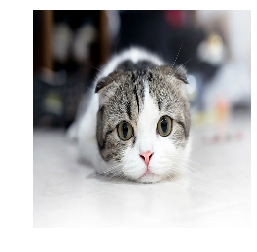

In [4]:
def predict_single_img(img):
    x = preprocess_input(img)  # VGG16 用の前処理を行う。
    x = np.expand_dims(x, axis=0)  # バッチの次元を追加する。

    # 推論する。
    scores = model.predict(x)[0]
    top3_classes = scores.argsort()[-3:][::-1]

    # 推論結果を表示する。
    for name, score in zip(class_names[top3_classes], scores[top3_classes]):
        print('{}: {:.2%}'.format(name, score))
    print()

img = cv2.imread('sample.jpg')  # 画像を読み込む。
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) # リサイズする。

# 推論する。
predict_single_img(img)

# 画像を描画する。
plt.axis('off')
plt.imshow(img)
plt.show()

In [5]:
sess = tf.keras.backend.get_session()

# Adversarial Examples 用のモデルを作成する。
target_class_input = tf.placeholder(dtype=tf.int32)
logits = sess.graph.get_tensor_by_name('predictions/BiasAdd:0')  # Softmax の直前

loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits, labels=[target_class_input])

gradient = tf.gradients(loss, model.input)

In [20]:
def find_adversary_noise(img, target_class,
                         noise_limit=3., required_score=0.99, max_iterations=100):
    noise = 0  # ノイズの初期値は0にする。

    # 画像の予測ラベル
    x = preprocess_input(img)
    x = np.expand_dims(x, axis=0)
    src_class = model.predict(x).argmax()

    for i in range(max_iterations):
        # 画像にノイズを加える。
        noisy_img = img + noise

        # 画素値を [0, 255] に収まるようにクリップする。
        noisy_img = np.clip(noisy_img, a_min=0, a_max=255)

        # 予測値及び勾配を計算する。
        x = preprocess_input(noisy_img)
        x = np.expand_dims(x, axis=0)
        pred, grad = sess.run([model.output, gradient],
                               feed_dict={model.input: x, target_class_input: target_class})
        pred = np.squeeze(pred)  # (1, NumClasses) -> (NumClasses,)
        grad = np.squeeze(grad)  # (1, 1, Height, Width, 3) -> (Height, Width, 3)

        # ステップ数を計算する。
        grad_absmax = np.abs(grad).max()
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10
        step_size = 7 / grad_absmax

        src_score = pred[src_class]  # 元の予測ラベルの確率
        target_score = pred[target_class]  # ターゲットのラベルの確率

        # 情報を表示する。
        print('[source] {} {:.2%} [target] {} {:.2%}'.format(
            class_names[src_class], src_score, class_names[target_class], target_score))
        print('[Gradient] min: {:.4f}, max: {:.4f}, stepsize: {:.4f}\n'.format(
            grad.min(), grad.max(), step_size))

        if target_score >= required_score:
            break

        # ノイズを更新する。
        noise -= step_size * grad
        # ノイズを [-noise_limit, noise_limit] に収まるようにクリップする。
        noise = np.clip(a=noise, a_min=-noise_limit, a_max=noise_limit)

    return noise

In [21]:
target_class = 9
noise = find_adversary_noise(img, target_class)

[source] タビー 48.31% [target] ダチョウ 0.00%
[Gradient] min: -0.0012, max: 0.0012, stepsize: 5714.8983

[source] タビー 16.88% [target] ダチョウ 0.54%
[Gradient] min: -0.0008, max: 0.0009, stepsize: 8012.7056

[source] タビー 10.39% [target] ダチョウ 10.58%
[Gradient] min: -0.0006, max: 0.0013, stepsize: 5265.2761

[source] タビー 7.92% [target] ダチョウ 41.78%
[Gradient] min: -0.0011, max: 0.0008, stepsize: 6124.4979

[source] タビー 1.64% [target] ダチョウ 73.10%
[Gradient] min: -0.0006, max: 0.0006, stepsize: 11588.4837

[source] タビー 0.56% [target] ダチョウ 93.48%
[Gradient] min: -0.0001, max: 0.0001, stepsize: 61973.4378

[source] タビー 0.10% [target] ダチョウ 98.15%
[Gradient] min: -0.0000, max: 0.0000, stepsize: 175244.5632

[source] タビー 0.09% [target] ダチョウ 99.31%
[Gradient] min: -0.0000, max: 0.0000, stepsize: 617446.0742



In [22]:
print('noise min: {:.4f}, max: {:.4f}, mean: {:.4f}, std: {:.4f}'.format(
    noise.min(), noise.max(), noise.mean(), noise.std()))

# ノイズを付加した画像を生成する。
noisy_img = np.clip(img + noise, a_min=0, a_max=255).astype(np.uint8)

predict_single_img(img)
predict_single_img(noisy_img)

noise min: -3.0000, max: 3.0000, mean: 0.0054, std: 1.5791
タビー: 48.31%
虎猫: 11.13%
エジプトの猫: 9.99%

ダチョウ: 99.21%
タビー: 0.10%
エジプトの猫: 0.08%



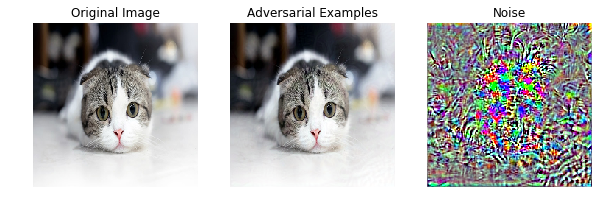

In [23]:
def array_to_img(x):
    '''[0, 1] に正規化
    '''
    return (x - x.min()) / (x.max() - x.min())

# 描画する。
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Original Image')
ax1.imshow(img)
ax1.set_axis_off()

ax2.set_title('Adversarial Examples')
ax2.imshow(noisy_img)
ax2.set_axis_off()

ax3.set_title('Noise')
ax3.imshow(array_to_img(noise))
ax3.set_axis_off()

plt.show()